# Monte Carlo Simulation for European Stock Options

This notebook implements various techniques to price European-style options using Monte Carlo simulation methods. We also compare the simulated prices with analytical solutions (Black-Scholes) and incorporate real-time data using Yahoo Finance.

## 1. Imports

In [ ]:
import numpy as np
from scipy.stats import norm
from scipy.stats.qmc import Sobol
import yfinance as yf
from datetime import datetime

## 2. Basic Monte Carlo Pricer

This function estimates the price of an option using basic Monte Carlo simulation of stock paths under the geometric Brownian motion assumption.

In [ ]:
def monte_carlo_option_price(
    initial_stock_price, strike_price, time_to_maturity, risk_free_rate, vol, option_type="call",
    N=100000, use_antithetic=False
):
    """
    Monte Carlo pricer for European call or put options
    """
    Z = np.random.randn(N) ## NORM(0,1)

    if use_antithetic:
        Z = np.concatenate((Z, -Z))  # Antithetic variates, doubles samples size, reduces variance

    ST = initial_stock_price * np.exp((risk_free_rate - 0.5 * vol**2) * time_to_maturity + vol * np.sqrt(time_to_maturity) * Z)

    if option_type == "call":
        payoff = np.maximum(ST - strike_price, 0)
    elif option_type == "put":
        payoff = np.maximum(strike_price - ST, 0)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    return np.exp(-risk_free_rate * time_to_maturity) * np.mean(payoff) ## final price


When the use_antithetic field is set to False (which is the defualt), it would be the naive Monte Carlo Simulation.

In [ ]:
# Example usage
S0 = 100     # initial stock price
K = 105      # strike price
T = 1.0      # time to maturity (1 year)
r = 0.05     # risk-free interest rate
sigma = 0.2  # volatility
N = 2**15   # number of simulations

# Call pricing
call_price = monte_carlo_option_price(S0, K, T, r, sigma, "call", N, use_antithetic=True)
put_price = monte_carlo_option_price(S0, K, T, r, sigma, "put", N, use_antithetic=True)

call_price_naive = monte_carlo_option_price(S0, K, T, r, sigma, "call", N, use_antithetic=False)
put_price_naive = monte_carlo_option_price(S0, K, T, r, sigma, "put", N, use_antithetic=False)

## Without Antithetic
print(f"European Call Price (Naive MC): {call_price_naive:.4f}")
print(f"European Put Price  (Naive MC): {put_price_naive:.4f}")

## with Antithetic
print(f"European Call Price (Antithetic MC): {call_price:.4f}")
print(f"European Put Price  (Antithetic MC): {put_price:.4f}")

European Call Price (Naive MC): 8.1501
European Put Price  (Naive MC): 7.8827
European Call Price (Antithetic MC): 8.1079
European Put Price  (Antithetic MC): 7.8744


## 3. Quasi Monte Carlo with Sobol Sequences

We will now implement a function that uses a Sobol sequence instead of pseudorandom numbers for variance reduction.

In [ ]:
# Parameters
S0 = 100
K = 105
T = 1.0
r = 0.05
sigma = 0.2
N = 2**22  # Must be a power of 2 for Sobol, make the power the parameter


def monte_carlo_option_price_qmc(intial_stock_price, strike_price, time_to_maturity=T, risk_free_rate=r, vol=sigma,
    N=2**22):

# 1. Generate Sobol sequence
  sobol_engine = Sobol(d=1, scramble=True)
  ## one dimensional, scrambling adds randomization for statistical error estimation
  u = sobol_engine.random(N)
  Z_qmc = norm.ppf(u.flatten())  # Transform to standard normal
  ## basically inverse transform theorem

# 2. Simulate stock paths
  ST = S0 * np.exp((risk_free_rate - 0.5 * vol**2) * time_to_maturity + vol * np.sqrt(time_to_maturity) * Z_qmc)

# 3. Calculate discounted payoff
  payoff = np.maximum(ST - K, 0)
  price = np.exp(-risk_free_rate * time_to_maturity) * np.mean(payoff)


  return price

price = monte_carlo_option_price_qmc(S0, K)

print(f"European Call Price using Quasi-MC (Sobol): {price:.4f}")

European Call Price using Quasi-MC (Sobol): 8.0214


### Timing Comparison: QMC vs Standard MC

In [ ]:
import time

t = time.process_time()
#do some stuff
price = monte_carlo_option_price_qmc(S0, K)
elapsed_time = time.process_time() - t
print(elapsed_time)


t = time.process_time()
#do some stuff
price = monte_carlo_option_price(S0, K, T, r, sigma, "call", N, use_antithetic=True)
elapsed_time = time.process_time() - t
print(elapsed_time)

0.38810236599999826
0.35613032900000263


## 4. Real-Time Market Data via Yahoo Finance

This funciton utilizes the Yahoo Finance API to fetch live market data. It will take inputs such as the ticker symbol, strike price, and expiry date and will return all of the inputs necessary for the Monte Carlo functions.

In [ ]:
def get_yahoo_market_data(ticker_symbol, strike_price, expiry_date=None):
    ticker = yf.Ticker(ticker_symbol)

    # Use the first available expiry date if none is provided
    if expiry_date is None:
        expiry_date = ticker.options[0]

    # Get option chain for given expiry date
    option_chain = ticker.option_chain(expiry_date)
    calls = option_chain.calls

    # Filter for the row with the desired strike price
    option_row = calls[calls['strike'] == strike_price]

    if option_row.empty:
        raise ValueError(f"No call option found at strike price {strike_price} for {ticker_symbol} on {expiry_date}")

    # Get current stock price
    S0 = ticker.history(period="1d")['Close'].iloc[-1]

    # Time to expiry in years
    expiry = datetime.strptime(expiry_date, "%Y-%m-%d")
    today = datetime.today()
    T = (expiry - today).days / 365

    # Risk-free rate (constant)
    r = 0.05

    # Get implied volatility
    sigma = option_row['impliedVolatility'].values[0]

    return S0, strike_price, T, r, sigma


In [ ]:
#Example usage

ticker = 'AAPL'
strike = 110

## we should also return last price as well
S0, K, T, r, sigma = get_yahoo_market_data(ticker, strike)

In [ ]:
print(f"\n📈 Live Market Inputs for {ticker} July 25, 2025 Call @ {strike}")
print(f"  S0     = {S0:.2f}")
print(f"  K      = {K}")
print(f"  T      = {T:.4f} years")
print(f"  r      = {r}")
print(f"  sigma  = {sigma:.4f}\n")


📈 Live Market Inputs for AAPL July 25, 2025 Call @ 110
  S0     = 212.48
  K      = 110
  T      = 0.0082 years
  r      = 0.05
  sigma  = 2.1094



In [ ]:
print(monte_carlo_option_price_qmc(S0, K))

102.52731447731101


## 5. Parallelized QMC

We would now like to enhance performance. To do so, we will utilize the Joblib package to run simulations in parallel across cores.

In [ ]:
### parallelized qmc
from joblib import Parallel, delayed
def qmc_price_european_option(
    intial_stock_price, strike, time_to_maturity, risk_free_rate, vol,
    option_type="call",  # "call" or "put"
    N=2**22, n_jobs=4, scramble=True
):
    if option_type not in {"call", "put"}:
        raise ValueError("option_type must be 'call' or 'put'")

    # Generate Sobol samples and map to N(0,1)
    sobol = Sobol(d=1, scramble=scramble)
    Z = norm.ppf(sobol.random(N).flatten())
    chunks = np.array_split(Z, n_jobs)

    results = Parallel(n_jobs=n_jobs)(
        delayed(lambda chunk: np.sum(np.exp(-risk_free_rate * time_to_maturity) * (
            np.maximum(
                S0 * np.exp((risk_free_rate - 0.5 * vol**2) * time_to_maturity + vol * np.sqrt(time_to_maturity) * chunk) - K,
                0
            ) if option_type == "call" else
            np.maximum(
                K - S0 * np.exp((risk_free_rate - 0.5 * vol**2) * time_to_maturity + vol * np.sqrt(time_to_maturity) * chunk),
                0
            )
        )))(chunk) for chunk in chunks
    )

    return np.sum(results) / N




In [ ]:
call = qmc_price_european_option(100, 105, 1.0, 0.05, 0.2, option_type="call")
print(f"Call Price: {call:.4f}")

# Put option
put = qmc_price_european_option(100, 105, 1.0, 0.05, 0.2, option_type="put")
print(f"Put Price:  {put:.4f}")

Call Price: 8.0213
Put Price:  7.9004


In [ ]:
print(qmc_price_european_option(S0, K, T, r, sigma, option_type="call"))

102.52730553782006


In [ ]:

print("\n--- Timing Comparison ---")

# Time Antithetic MC
start_time = time.time()
call_price_anti = monte_carlo_option_price(S0, K, T, r, sigma, "call", N, use_antithetic=True)
end_time = time.time()
print(f"Antithetic MC time: {end_time - start_time:.6f} seconds")
print(f"Antithetic MC Call Price: {call_price_anti:.4f}")


# Time QMC (Sobol)
start_time = time.time()
call_price_qmc = monte_carlo_option_price_qmc(S0, K, T, r, sigma, N=2**20) # Using a larger N for QMC
end_time = time.time()
print(f"QMC (Sobol) time: {end_time - start_time:.6f} seconds")
print(f"QMC (Sobol) Call Price: {call_price_qmc:.4f}")

# Time Parallelized QMC
start_time = time.time()
call_price_parallel_qmc = qmc_price_european_option(S0, K, T, r, sigma, option_type="call", N=2**20, n_jobs=4)
end_time = time.time()
print(f"Parallelized QMC time: {end_time - start_time:.6f} seconds")
print(f"Parallelized QMC Call Price: {call_price_parallel_qmc:.4f}")



--- Timing Comparison ---
Antithetic MC time: 0.333616 seconds
Antithetic MC Call Price: 102.5251
QMC (Sobol) time: 0.092344 seconds
QMC (Sobol) Call Price: 102.5273
Parallelized QMC time: 0.212168 seconds
Parallelized QMC Call Price: 102.5273


In [73]:
import jax
import jax.numpy as jnp
from scipy.stats.qmc import Sobol
from scipy.stats import norm

@jax.jit
def bsm_payoff(S0, K, T, r, sigma, Z, is_call):
    ST = S0 * jnp.exp((r - 0.5 * sigma**2) * T + sigma * jnp.sqrt(T) * Z)


    def call_payoff(_):
        return jnp.mean(jnp.maximum(ST - K, 0.0)) * jnp.exp(-r * T)

    def put_payoff(_):
        return jnp.mean(jnp.maximum(K - ST, 0.0)) * jnp.exp(-r * T)

    return jax.lax.cond(is_call, call_payoff,
                        put_payoff, operand=None)

def qmc_price_jax(initial_stock_price, strike, time_to_maturity, risk_free_rate, vol, is_call, N=2**22):
    u = jnp.linspace(0, 1, N, endpoint=False) + 0.5 / N
    Z = jnp.array(norm.ppf(u))  # Convert to JAX array
    return bsm_payoff(initial_stock_price, strike, time_to_maturity, risk_free_rate, vol, Z, is_call)


In [89]:

# Time JAX QMC
start_time = time.time()
# JAX functions need a warmup run
_ = qmc_price_jax(S0, K, T, r, sigma, is_call=True, N=2**22).block_until_ready()
call_price_jax_qmc = qmc_price_jax(S0, K, T, r, sigma, is_call=True, N=2**22).block_until_ready()
end_time = time.time()
print(f"JAX QMC time: {end_time - start_time:.6f} seconds")
print(f"JAX QMC Call Price: {call_price_jax_qmc:.4f}")

JAX QMC time: 0.566175 seconds
JAX QMC Call Price: 8.0214


## 6. Control Variates

We would now like to explore a bit more variance reduction. Specifically, we will apply the control variates technique by comparing our simulated price with the known Black-Scholes formula.

In [ ]:
## control variate code


def european_option_with_control_variate(initial_stock_price, strike_price, time_to_maturity, risk_free_rate, vol, option_type="call", N=2**22):
    Z = np.random.randn(N) ## NORM(0,1)

    ST = initial_stock_price * np.exp((r - 0.5 * vol**2) * time_to_maturity + vol * np.sqrt(time_to_maturity) * Z)

    if option_type == "call":
        payoff = np.maximum(ST - strike_price, 0)
    elif option_type == "put":
        payoff = np.maximum(strike_price - ST, 0)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    Y = ST
    EY = S0 * np.exp(r * time_to_maturity) ## mathematical formula here

    # Step 5: Compute beta = Cov(X, Y) / Var(Y)
    cov_xy = np.cov(payoff, Y, bias=True)[0, 1]
    var_y = np.var(Y)
    beta = cov_xy / var_y

    # Step 6: Control variate adjustment
    Z_cv = payoff - beta * (Y - EY)

    # Step 7: Discount result
    return np.mean(Z_cv) * np.exp(-risk_free_rate * time_to_maturity)


In [ ]:
## Setting Variables
S0 = 100     # initial stock price
K = 105      # strike price
T = 1.0      # time to maturity (1 year)
r = 0.05     # risk-free interest rate
sigma = 0.2  # volatility
N = 2**15   # number of simulations

print(european_option_with_control_variate(S0,K, T, r, sigma, "call", N))

8.018366176563358


In [64]:
## Closed Form Black-Scholes Option Pricer (Calls/Puts)
def closed_form_black_scholes(intial_stock_price, strike_price,
                              time_to_maturity, risk_free_rate, vol, option_type="call"):

  d1 = (np.log(intial_stock_price / strike_price) + (risk_free_rate + 0.5 * vol**2) * time_to_maturity) / (vol * np.sqrt(time_to_maturity))
  d2 = d1 - vol * np.sqrt(time_to_maturity)

  if option_type == "call":
    return intial_stock_price * norm.cdf(d1) - strike_price * np.exp(-risk_free_rate * time_to_maturity) * norm.cdf(d2)
  else:
    return strike_price * np.exp(-risk_free_rate * time_to_maturity) * norm.cdf(-d2) - intial_stock_price * norm.cdf(-d1)





print(closed_form_black_scholes(S0,K, T, r, sigma, "call"))


8.021352235143176


## 7. Plotting our Results

Running convergence tests...
  Running for N = 1024
  Running for N = 2048
  Running for N = 4096
  Running for N = 8192
  Running for N = 16384
  Running for N = 32768
  Running for N = 65536
  Running for N = 131072
  Running for N = 262144
  Running for N = 524288
  Running for N = 1048576


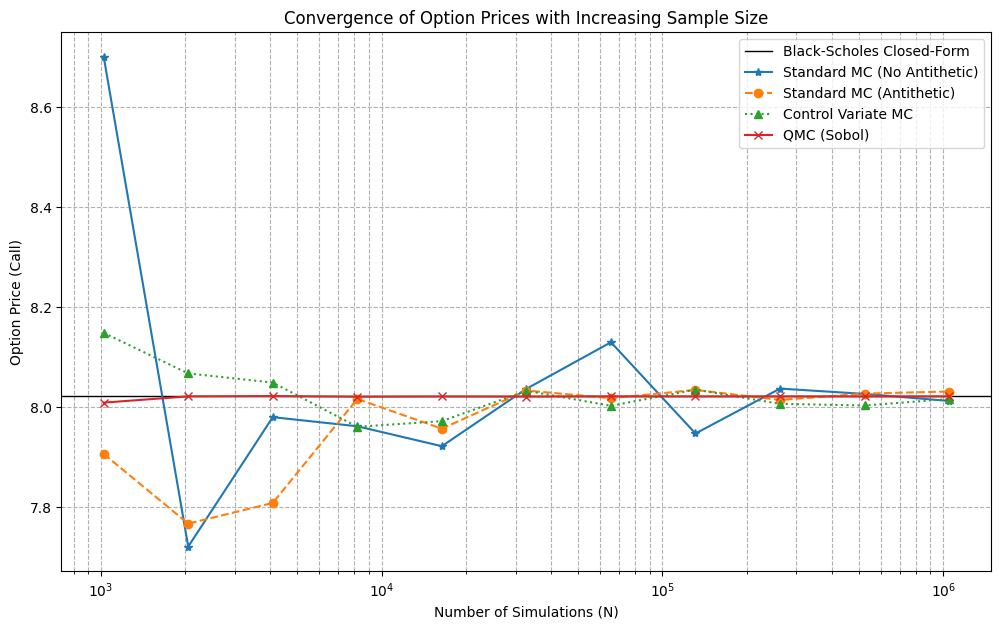

In [72]:

import matplotlib.pyplot as plt

# Parameters
S0 = 100
K = 105
T = 1.0
r = 0.05
sigma = 0.2

# Range of sample sizes (powers of 2 are good for Sobol)
sample_sizes = [2**i for i in range(10, 21)] # Start from 2^10

# Lists to store results
mc_prices = []
mc_prices_a = []
c_prices = []
qmc_prices = []


print("Running convergence tests...")
for N in sample_sizes:
    print(f"  Running for N = {N}")


    # Standard MC (without antithetic variate/no variance reduction)
    mc_price = monte_carlo_option_price(S0, K, T, r, sigma, "call", N, use_antithetic=False)
    mc_prices.append(mc_price)

    # Standard MC (with antithetic variates)
    mc_price_a = monte_carlo_option_price(S0, K, T, r, sigma, "call", N, use_antithetic=True)
    mc_prices_a.append(mc_price_a)


    ## Control Variate MC

    c_price  = european_option_with_control_variate(S0, K, T, r, sigma, "call", N)
    c_prices.append(c_price)
    # QMC (Sobol)
    qmc_price = monte_carlo_option_price_qmc(S0, K, T, r, sigma, N=N)
    qmc_prices.append(qmc_price)


# Plotting the convergence
plt.figure(figsize=(12, 7))

plt.axhline(y=closed_form_black_scholes(S0, K, T, r, sigma, "call"), color='black', linestyle='-', linewidth=1, label='Black-Scholes Closed-Form')

plt.plot(sample_sizes, mc_prices, label='Standard MC (No Antithetic)', marker='*', linestyle='-')
plt.plot(sample_sizes, mc_prices_a, label='Standard MC (Antithetic)', marker='o', linestyle='--')
plt.plot(sample_sizes, c_prices, label='Control Variate MC', marker='^', linestyle=':')
plt.plot(sample_sizes, qmc_prices, label='QMC (Sobol)', marker='x')


plt.xscale('log')
plt.xlabel('Number of Simulations (N)')
plt.ylabel('Option Price (Call)')
plt.title('Convergence of Option Prices with Increasing Sample Size')
plt.legend()
plt.grid(True, which="both", linestyle='--')
plt.show()


## 8. Conclusion

This end-to-end simulation framework demonstrates the power and flexibility of simulation-based methods, particularly Monte-Carlo, in the financial modeling space. Future work could extend this to price American options, estimate the Greeks, or visualize convergence with confidence intervals.